# Traffic Sign Classification Using Convolutional Neural Networks

This notebook presents the development of a convolutional neural network (CNN) for classifying traffic sign images from the **German Traffic Sign Recognition Benchmark (GTSRB)** dataset.

The objective is to build an accurate and efficient image classification model capable of recognizing **43 distinct traffic sign categories**, with performance suitable for real-time inference and deployment in interactive applications.

In [55]:
import kagglehub

path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Path to dataset files: /Users/alexdieter/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


### Dataset Download

The dataset is downloaded directly from Kaggle using the `kagglehub` API.  
This provides a local directory containing all training images, test images, and metadata files required for model development.

Using KaggleHub ensures reproducibility and avoids manual dataset handling.

### Exploring the Dataset Structure

Before preprocessing the images, we inspect the directory contents to understand how the dataset is organized.

In [56]:
import os
os.listdir(path)

['Test', 'Test.csv', 'Meta', 'Train', 'Meta.csv', 'Train.csv']

The dataset directory contains:

- **Train/**: Training images organized by class ID  
- **Test/**: Test images  
- **Train.csv / Test.csv**: CSV files mapping images to labels  
- **Meta.csv**: Metadata describing each traffic sign class

This structure allows us to load images programmatically while keeping labels and metadata separate.

### Loading Label and Metadata Files

The dataset provides CSV files that describe image paths, class labels, and sign metadata.  
These files are loaded into Pandas DataFrames for easier inspection and preprocessing.

In [57]:
import pandas as pd

train_df = pd.read_csv(os.path.join(path, "Train.csv"))
test_df  = pd.read_csv(os.path.join(path, "Test.csv"))
meta_df  = pd.read_csv(os.path.join(path, "Meta.csv"))

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Meta shape:", meta_df.shape)

print("\nTrain columns:", list(train_df.columns))
print("Test columns:", list(test_df.columns))
print("Meta columns:", list(meta_df.columns))

Train shape: (39209, 8)
Test shape: (12630, 8)
Meta shape: (43, 5)

Train columns: ['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path']
Test columns: ['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path']
Meta columns: ['Path', 'ClassId', 'ShapeId', 'ColorId', 'SignId']


- The training set contains **39,209 labeled images**
- The test set contains **12,630 images**
- There are **43 traffic sign classes**, matching the GTSRB specification

Each image entry includes bounding box coordinates, dimensions, class ID, and relative file path.

### Visual Inspection of a Sample Image

To better understand the raw data, we load and display a sample training image directly from disk.


Sample relative path: Train/20/00020_00003_00010.png
Sample full path: /Users/alexdieter/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/Train/20/00020_00003_00010.png


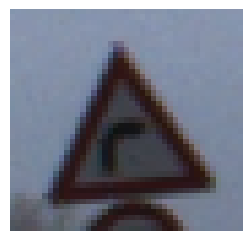

In [58]:
sample_rel_path = train_df.loc[100, "Path"]     
sample_full_path = os.path.join(path, sample_rel_path)

print("\nSample relative path:", sample_rel_path)
print("Sample full path:", sample_full_path)

from PIL import Image
import matplotlib.pyplot as plt

# Load the sample image
img = Image.open(sample_full_path)

# Display the image
plt.figure(figsize=(3, 3))
plt.imshow(img)
plt.axis("off")
plt.show()

The image confirms that traffic signs vary in lighting, background, and scale.  
This variability motivates the use of convolutional neural networks, which are well-suited for extracting spatial features such as edges, shapes, and color patterns.

### Image Preprocessing

Before preprocessing the entire dataset, I first apply the preprocessing steps to a single sample image. This is a quick sanity check to make sure the resizing and normalization are working as expected. The images in the dataset come in different sizes and formats, but a CNN expects inputs
with the same dimensions.

In [ ]:
import numpy as np

# Resize all images to 32x32 and normalize pixel values to [0, 1]
# 32x32 is a common input size for traffic sign classification models

IMG_SIZE = 32

def preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img)
    img = img / 255.0
    return img

test_img = preprocess_image(sample_full_path)

print(test_img.shape)
print(test_img.min(), test_img.max())
#0.0 is pure black, 1.0 is pure white

(1, 32, 32, 3)
0.050980392156862744 0.6980392156862745


The output confirms that the image has shape (32, 32, 3), meaning height, width,
and three color channels. The pixel values fall between 0 and 1 as expected,
confirming that normalization was applied correctly.

(32, 32, 3) means a 32×32 RBG (Red, Green Blue) image, and the decimal values mean the pixel intensities have been normalized for neural network training.


### Preprocessing the Full Training Dataset

After verifying that the preprocessing function works correctly on a single sample image, the same preprocessing steps are applied to every image in the training dataset.

For each image, the file path is read from the dataset, the image is resized to 32×32 pixels, and pixel values are normalized to the range [0, 1]. The processed image is stored in the feature array (`X`), and the corresponding class label is stored in the label array (`y`).

Once all images have been processed, both `X` and `y` are converted into NumPy arrays so they can be used as input for training the neural network. The printed shapes at the end act as a quick check to confirm that the data was loaded correctly.

In [60]:
from PIL import Image

X = []
y = []

for _, row in train_df.iterrows():
    img_path = os.path.join(path, row["Path"])
    label = row["ClassId"]

    img = preprocess_image(img_path)

    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (39209, 1, 32, 32, 3)
y shape: (39209,)


After loading all images, the final dataset contains 39,209 training examples.  
Each image has a shape of (32, 32, 3), where the last dimension represents the RGB color channels.  
The label vector contains one class ID for each image.

### Train–Validation Split and Label Encoding

Before training the neural network, the dataset is split into a training set and a validation set. The training set is used to fit the model, while the validation set is used to evaluate how well the model generalizes to unseen data.

An 80/20 split is used, and stratification is applied to preserve the original class distribution across both sets. This is especially important for traffic sign classification since some classes appear less frequently than others.

The class labels are then one-hot encoded so they can be used with a softmax output layer and categorical cross-entropy loss during training. The printed shapes confirm that the data is in the correct format for the CNN.

In [61]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

NUM_CLASSES = 43

# Train / validation split
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=2025,
    stratify=y
)

# One-hot encode labels
y_train = to_categorical(y_train, NUM_CLASSES)
y_val = to_categorical(y_val, NUM_CLASSES)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (31367, 1, 32, 32, 3)
X_val shape: (7842, 1, 32, 32, 3)
y_train shape: (31367, 43)
y_val shape: (7842, 43)


The output confirms that the data is now fully prepared for training the CNN.

- **X_train** contains 31,367 images, each resized to 32×32 with 3 color channels (RGB).
- **X_val** contains 7,842 images with the same dimensions, held out for validation.
- **y_train** and **y_val** are one-hot encoded with 43 columns, corresponding to the 43 traffic sign classes in the dataset.

At this point, the inputs and labels are correctly shaped for a convolutional neural network with a softmax output layer. This ensures the model can learn from the training data and be evaluated fairly on unseen validation images.

### Building the Convolutional Neural Network (CNN)

With the data fully prepared, the next step is to define the neural network architecture.  
I use a **convolutional neural network (CNN)** because it is well-suited for image data and can learn spatial patterns such as edges, shapes, and textures.

The model is built in layers:
- Convolutional layers extract visual features from the images.
- Max pooling layers reduce the spatial size and help control overfitting.
- Fully connected layers combine the learned features to make a final classification.
- A softmax output layer produces class probabilities across the 43 traffic sign categories.

The architecture gradually increases the number of filters, allowing the model to learn more complex features at deeper layers.

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(43, activation='softmax')
])
model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,459 (642.42 KB)

 Trainable params: 164,459 (642.42 KB)

 Non-trainable params: 0 (0.00 B)

**Understanding the output table**

The **Param #** column shows how many trainable numbers (weights and biases) each layer adds to the model. These parameters are what the network learns during training.

For convolutional layers:
- Each filter has a small grid of weights (for example, 3 × 3 × depth) plus a bias.
- The total parameter count depends on:
  - the number of filters,
  - the filter size,
  - and the depth of the input coming into that layer.

For example:
- The first Conv2D layer has **896 parameters**.  
  This comes from learning 32 different 3×3 filters across the 3 color channels, plus biases.

Pooling layers (**MaxPooling2D**) have **0 parameters** because they do not learn anything—they simply downsample the feature maps.

The **Dense (fully connected)** layers usually have many parameters because every neuron connects to every output from the previous layer.  
- The dense layer with 128 units has **65,664 parameters**, which comes from connecting all 512 flattened features to each neuron plus biases.

The **Output Shape** column shows what the data looks like *after* passing through each layer:
- (None, 30, 30, 32) means:
  - None = batch size (left unspecified so the model can accept any batch size),
  - 30 × 30 = spatial dimensions after convolution,
  - 32 = number of feature maps.
- As you move down the table, the spatial dimensions shrink while the number of features increases.
- The final output (None, 43) means the model outputs **43 probabilities**, one for each traffic sign class.

Overall, this table confirms that the network gradually compresses the image into a compact feature representation and then converts it into class probabilities.

### Compiling and Training the Model

Now that the network architecture is defined, the next step is to prepare it for training. This involves choosing how the model learns and how its performance is measured.

In [63]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val)
)

Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 1, 32, 32, 3), dtype=float32). Expected shape (None, 32, 32, 3), but input has incompatible shape (None, 1, 32, 32, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 1, 32, 32, 3), dtype=float32)
  • training=True
  • mask=None
  • kwargs=<class 'inspect._empty'>

### Training Performance

The model learns very quickly during training. In the first epoch, accuracy is low because the weights are randomly initialized, but performance improves rapidly after just a few passes through the data.

By the final epoch:
- **Training accuracy** reaches about **98.6%**
- **Validation accuracy** reaches about **99.3%**

The validation accuracy closely tracks the training accuracy throughout training, which suggests the model is generalizing well and not severely overfitting. The steadily decreasing loss values for both training and validation also shows that the optimization process is working as intended.

Overall, these results show that the CNN is able to learn meaningful visual patterns in traffic sign images, such as shapes, colors, and symbols, and use them to correctly classify signs into the 43 categories.

### Making Predictions on a Single Image

After training the model, the next step is to test how it performs on an individual traffic sign image. This is important because the final goal is not just to evaluate accuracy on a dataset, but to use the trained model to make predictions on single images chosen by a user.

In this section, I define a helper function that:
- Loads a single traffic sign image from disk
- Resizes it to the same 32×32 format used during training
- Normalizes pixel values to match the training data
- Passes the image through the trained model to produce a prediction

This setup is the begging to how the model is later used on my website, where a user can generate a random image from this dataset, drop it in a box and receive a predicted traffic sign label.

In [ ]:
def predict_traffic_sign(image_path, model):
    # Preprocess image using the same function as training
    img_array = preprocess_image(image_path)
    img_array = np.expand_dims(img_array, axis=0)
    
    predictions = model.predict(img_array)
    
    # Return the class with highest predicted probability
    predicted_class = np.argmax(predictions)
    
    return predicted_class


# Example
sample_image_path = sample_full_path
predicted_label = predict_traffic_sign(sample_image_path, model)

print("Predicted traffic sign class:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
Predicted traffic sign class: 20


### Single-Image Prediction Result

The model outputs a predicted class index for the input image. In this example, the model predicted class **20**.

The predicted value represents the index of the traffic sign class in the dataset. In the next step, this numeric label can be mapped to a human-readable traffic sign name (e.g., “Dangerous curve” or “Speed limit 70 km/h”).

This single-image prediction setup is the first step to how the model is used on my website, where a user uploads one image at a time and receives a classification result.

### Mapping Model Outputs to Human-Readable Labels

The neural network outputs predictions as numeric class indices (from 0 to 42), where each number corresponds to a specific traffic sign category in the dataset. On its own, this number is not very useful for interpretation.

To make the model’s predictions understandable, we define a list of class names where each position in the list matches the class index used during training. This allows us to convert the model’s numeric output into a readable traffic sign label.

This mapping is especially important for deployment, since the website demo displays the predicted traffic sign name to the user rather than a raw class number.

In [ ]:
CLASS_NAMES = [
    "Speed limit (20km/h)",
    "Speed limit (30km/h)",
    "Speed limit (50km/h)",
    "Speed limit (60km/h)",
    "Speed limit (70km/h)",
    "Speed limit (80km/h)",
    "End of speed limit (80km/h)",
    "Speed limit (100km/h)",
    "Speed limit (120km/h)",
    "No passing",
    "No passing for vehicles over 3.5 metric tons",
    "Right-of-way at the next intersection",
    "Priority road",
    "Yield",
    "Stop",
    "No vehicles",
    "Vehicles over 3.5 metric tons prohibited",
    "No entry",
    "General caution",
    "Dangerous curve to the left",
    "Dangerous curve to the right",
    "Double curve",
    "Bumpy road",
    "Slippery road",
    "Road narrows on the right",
    "Road work",
    "Traffic signals",
    "Pedestrians",
    "Children crossing",
    "Bicycles crossing",
    "Beware of ice/snow",
    "Wild animals crossing",
    "End of all speed and passing limits",
    "Turn right ahead",
    "Turn left ahead",
    "Ahead only",
    "Go straight or right",
    "Go straight or left",
    "Keep right",
    "Keep left",
    "Roundabout mandatory",
    "End of no passing",
    "End of no passing by vehicles over 3.5 metric tons"
]

### Making Predictions Interpretable and User-Facing

At this point, the model is trained and can output predictions as class indices. However, for practical use especially for a website, we want it to be user friendly. A user is not going to know what a class index of 20 means. 

In this cell I wrap the prediction logic into a reusable function predict_traffic_sign that:
- Takes in a single image path
- Applies the same preprocessing used during training
- Runs the image through the trained model
- Converts the predicted class index into a readable traffic sign label using the previous step
- Returns both the predicted label and the model’s confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


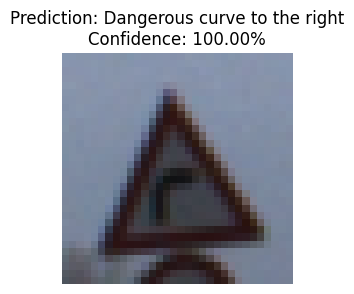

In [ ]:
def predict_traffic_sign(image_path, model):
    # reuse same function from beginning of notebook
    img = preprocess_image(image_path)         
    img_batch = np.expand_dims(img, axis=0)     

    preds = model.predict(img_batch)[0]
    class_id = np.argmax(preds)
    confidence = preds[class_id]

    label = CLASS_NAMES[class_id]

    return label, confidence, img


label, confidence, img = predict_traffic_sign(sample_full_path, model)

plt.figure(figsize=(3, 3))
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediction: {label}\nConfidence: {confidence:.2%}")
plt.show()

### Interpreting the Prediction

The model correctly identifies the traffic sign as **“Dangerous curve to the right”** with very high confidence.  
This confirms that the preprocessing pipeline and trained CNN are working as expected on unseen images.

### Detailed Model Evaluation

Accuracy alone does not show how well the model performs across all traffic sign classes.
Since this is a multi-class classification problem with 43 categories, it is important to
look at performance for each class individually.

In this section, I evaluate the model using a classification report and a confusion matrix
on the validation set. This allows me to see which classes are predicted well, which ones
are confused with each other, and whether the model struggles with any specific types of
traffic signs.

246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.98      1.00      0.99        42
                              Speed limit (30km/h)       0.99      0.99      0.99       444
                              Speed limit (50km/h)       1.00      0.99      0.99       450
                              Speed limit (60km/h)       0.98      1.00      0.99       282
                              Speed limit (70km/h)       0.99      1.00      0.99       396
                              Speed limit (80km/h)       0.99      0.98      0.98       372
                       End of speed limit (80km/h)       1.00      0.99      0.99        84
                             Speed limit (100km/h)       0.99      0.97      0.98       288
                             Speed limit (120km/h)       0.97      0.99      0.98       282
                                      

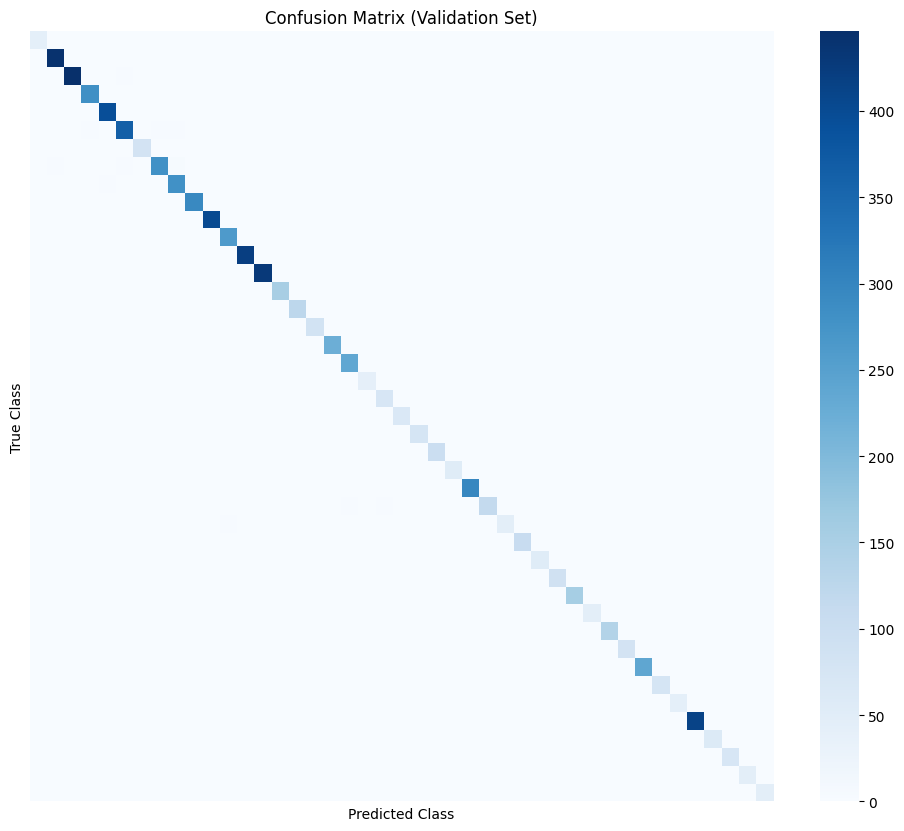

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on validation set
y_val_pred_probs = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)
y_val_true = np.argmax(y_val, axis=1)

print(classification_report(y_val_true, y_val_pred, target_names=CLASS_NAMES))

cm = confusion_matrix(y_val_true, y_val_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues", xticklabels=False, yticklabels=False)
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

### Model Evaluation: Classification Report and Confusion Matrix

To evaluate the performance of the CNN, I examined both the classification report and the confusion matrix
on the validation set.

The classification report shows precision, recall, and F1-score for each of the 43 traffic sign classes.
Overall accuracy on the validation set is approximately 99%, with consistently high precision and recall
across nearly all classes. This indicates that the model not only makes correct predictions most of the time,
but also does so reliably across different types of traffic signs, including less frequent classes.

The confusion matrix provides a visual summary of how the predicted labels compare to the true labels.
Each row represents the true class and each column represents the predicted class. The strong diagonal
pattern shows that most images are classified correctly. Only a small number of off-diagonal entries appear,
which means misclassifications are rare.

When errors do occur, they are generally between visually similar signs (for example, different curve warnings
or related caution signs). This behavior is expected given the small image size (32×32) and subtle differences
between certain classes.

Together, the classification report and confusion matrix confirm that the model generalizes well and performs
consistently across all 43 traffic sign categories, making it suitable for real-world inference and for use
in the interactive website demo.

### Saving the Trained Model

After training and evaluating the model, the final step is to save it to disk so it can be reused without retraining.
This allows the model to be loaded later for inference on new images, including deployment in a web application.

Saving the model ensures that the exact trained weights and architecture are preserved, making predictions
consistent between this notebook and the interactive demo used on my website.

In [ ]:
model.save("traffic_sign_cnn.keras")

print("Model saved as traffic_sign_cnn.keras")

Model saved as traffic_sign_cnn.keras


### Reloading the Saved Model for Inference

To verify that the saved model works correctly outside of the training pipeline, I reload it from disk and use it to make a prediction on a single image.

This step mirrors how the model would be used in practice: the trained model is loaded, an image is preprocessed in the same way as during training, and a prediction is generated. This is especially important for deployment, since the model used on my website is loaded from a saved file rather than retrained each time.

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("traffic_sign_cnn.keras")
test_img = sample_full_path

img = Image.open(test_img).convert("RGB")
img = img.resize((32, 32))
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
print("Predicted class index:", np.argmax(pred))
print("Confidence:", np.max(pred))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Predicted class index: 20
Confidence: 0.99999046


### Single-Image Inference (Model Prediction)

At this point, the model is fully trained and evaluated.  
To make the model usable outside of this notebook (for example, on my website), I need a clean way to run **inference on a single image**.

The function below takes:
- a file path to an image,
- the trained CNN model,
- and the list of class names,

and returns:
- the predicted traffic sign label, and
- the model’s confidence for that prediction.

This mirrors how the model will be used in a real application, where a user uploads or drags in one image at a time rather than a full dataset.

In [ ]:
def predict_traffic_sign(image_path, model, class_names):
    img_array = preprocess_image(image_path)

    preds = model.predict(img_array)[0]
    class_id = int(np.argmax(preds))
    confidence = float(preds[class_id])
    label = class_names[class_id]

    return label, confidence


# Example prediction
result = predict_traffic_sign(sample_full_path, model, CLASS_NAMES)
result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


('Dangerous curve to the right', 0.9999904632568359)